In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch import nn
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.feature_extraction.text import TfidfVectorizer
from torchtext.vocab import GloVe,vocab
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          GPT2PreTrainedModel,
                          GPT2Model)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import SequenceClassifierOutputWithPast

In [2]:
def convert_personality_type_to_binary(mbti_type):
    mapper = {
        'I':0,
        'E':1,
        'N':0,
        'S':1,
        'T':0,
        'F':1,
        'J':0,
        'P':1,
    }

    return [mapper[i] for i in mbti_type]

def convert_personality_type_to_int(mbti_type):
    types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]
    ints = [i for i in range(len(types))]
    mapper = dict(zip(types, ints))

    return mapper[mbti_type]

def convert_binary_to_personality_type(binary_mbti_type):
    mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
    mbti_string = ''
    for idx, mbti_type in enumerate(binary_mbti_type):
        mbti_string += mbti_arrays[idx][int(mbti_type)]
    return mbti_string

In [3]:
class MBTIDataset(Dataset):
    def __init__(self, data_path, vectorizing_method = None, binary_outputs = False, max_seq_len=500):
        """
        Vectorizing methods:
        None - returns raw text
        basic - basic builtin pytorch vectorizer
        TfIdf - tf-idf vectorizer
        GloVe - Global Vectors pretrained embedding
        """
        self.df = pd.read_csv(data_path)
        self.vectorizing_method = vectorizing_method
        self.max_seq_len = max_seq_len
        self.split_dataframe(self.max_seq_len)

        if vectorizing_method:
            if vectorizing_method.lower == 'basic':
                self.tokenizer = get_tokenizer('basic_english')
                self.vocab = build_vocab_from_iterator(self.yield_tokens_from_dataframe(), specials=['<unk>'])
                self.vocab.set_default_index(self.vocab["<unk>"])

            if vectorizing_method.lower == 'tfidf' or vectorizing_method.lower == 'tf-idf':
                self.tokenizer = TfidfVectorizer(stop_words= 'english')
                self.vocab = self.tokenizer.fit_transform(self.df['posts']) # Sparse matrix representation - could use different field names
            if vectorizing_method.lower == 'glove':
                unk_index = 0
                self.global_vectors = GloVe(name='6B', dim=50)
                self.vocab=vocab(self.global_vectors.stoi)
                self.vocab.insert_token("<unk>",unk_index)
                self.vocab.set_default_index(unk_index)

                self.pretrained_embeddings = self.global_vectors.vectors
                self.pretrained_embeddings = torch.cat((torch.zeros(1,self.pretrained_embeddings.shape[1]),self.pretrained_embeddings))


        self.binary_outputs = binary_outputs
        if binary_outputs:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_binary)
        else:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_int)

    def yield_tokens_from_dataframe(self):
        for post in self.df['posts']:
            yield self.tokenizer(post)

    def split_dataframe(self, new_seq_len):
        new_df = pd.DataFrame(columns=self.df.columns)
        new_posts = []
        new_types = []
        for idx, row in self.df.iterrows():
            split_posts = row['posts'].split(' ')
            i = 0
            while i < len(split_posts):
                new_posts.append((' ').join(split_posts[i:i+new_seq_len]))
                new_types.append(row['type'])
                i += new_seq_len

        new_df['posts'] = new_posts
        new_df['type'] = new_types
        self.df = new_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError

        if not self.vectorizing_method :
            return self.df['posts'][idx], self.df['type'][idx]  #Return raw text

        input_text = self.vocab(self.df['posts'][idx].split(' '))
        if len(input_text) < self.max_seq_len:
            input_text.extend([0] * (self.max_seq_len-len(input_text)))
        label = self.df['type'][idx]

        return input_text[0:self.max_seq_len], label

In [4]:
class RoBERTaClassificationCollator(object):

    def __init__(self, use_tokenizer, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        return

    def __call__(self, sequences):

        # Get all texts from sequences list.
        texts = [sequence[0] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence[1] for sequence in sequences]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [5]:
max_seq_len = 500
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer.padding_side = "right"
bert_classificaiton_collator = RoBERTaClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)


ds = MBTIDataset('../input/mbti-personality-types-500-dataset/MBTI 500.csv', vectorizing_method = None, binary_outputs=False, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [6]:
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 16, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    #problem_type="multi_label_classification",
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    ignore_mismatched_sizes=True #https://github.com/huggingface/transformers/issues/14218
)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
epochs = 2
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

cuda


In [8]:
for epoch in range(epochs):
    model.train()
    
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0
    # For each batch of training data...
    i = 0
    i_to_zero_count = 0
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
        
        if i % 500 == 0 :
            i=0
            i_to_zero_count += 1
            print(total_loss / (i_to_zero_count * 500 * 8))
                  
        i += 1

    avg_epoch_loss = total_loss / len(train_dataloader)
    print(avg_epoch_loss)
    
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content

    avg_epoch_loss = total_loss / len(val_dataloader)
    print(avg_epoch_loss)

  0%|          | 1/10400 [00:02<6:31:11,  2.26s/it]

0.0006861466169357299


  5%|▍         | 501/10400 [07:06<2:21:48,  1.16it/s]

0.13686752897500992


 10%|▉         | 1001/10400 [14:14<2:14:00,  1.17it/s]

0.15798589687546094


 14%|█▍        | 1501/10400 [21:24<2:06:31,  1.17it/s]

0.156287983675953


 19%|█▉        | 2001/10400 [28:33<1:59:04,  1.18it/s]

0.15371586127169432


 24%|██▍       | 2501/10400 [35:42<1:51:10,  1.18it/s]

0.15015634815363835


 29%|██▉       | 3001/10400 [42:51<1:45:37,  1.17it/s]

0.14702099508100322


 34%|███▎      | 3501/10400 [49:59<1:38:33,  1.17it/s]

0.14431593517400323


 38%|███▊      | 4001/10400 [57:08<1:31:43,  1.16it/s]

0.14184004937029548


 43%|████▎     | 4501/10400 [1:04:17<1:24:05,  1.17it/s]

0.13966273031104356


 48%|████▊     | 5001/10400 [1:11:25<1:17:04,  1.17it/s]

0.13689256738092412


 53%|█████▎    | 5501/10400 [1:18:34<1:08:59,  1.18it/s]

0.13476035012118517


 58%|█████▊    | 6001/10400 [1:25:43<1:02:19,  1.18it/s]

0.13242711086370623


 63%|██████▎   | 6501/10400 [1:32:51<55:49,  1.16it/s]  

0.13083063606764855


 67%|██████▋   | 7001/10400 [1:39:59<48:11,  1.18it/s]

0.1295562781732219


 72%|███████▏  | 7501/10400 [1:47:08<41:56,  1.15it/s]

0.12811594948309357


 77%|███████▋  | 8001/10400 [1:54:16<34:35,  1.16it/s]

0.12651199268256588


 82%|████████▏ | 8501/10400 [2:01:25<27:14,  1.16it/s]

0.12527033880161537


 87%|████████▋ | 9001/10400 [2:08:33<20:10,  1.16it/s]

0.1242930280905413


 91%|█████████▏| 9501/10400 [2:15:41<12:44,  1.18it/s]

0.12333903070527595


 96%|█████████▌| 10001/10400 [2:22:50<05:41,  1.17it/s]

0.12228766972400869


100%|██████████| 10400/10400 [2:28:32<00:00,  1.17it/s]


1.0174015002513233


100%|██████████| 2972/2972 [15:17<00:00,  3.24it/s]


0.8154402010328943


  0%|          | 1/10400 [00:00<2:26:37,  1.18it/s]

0.00021482515335083009


  5%|▍         | 501/10400 [07:08<2:21:36,  1.17it/s]

0.047129581773653624


 10%|▉         | 1001/10400 [14:17<2:13:49,  1.17it/s]

0.06241930346454804


 14%|█▍        | 1501/10400 [21:25<2:06:10,  1.18it/s]

0.07172391473525204


 19%|█▉        | 2001/10400 [28:33<2:00:38,  1.16it/s]

0.07601146510690451


 24%|██▍       | 2501/10400 [35:42<1:53:05,  1.16it/s]

0.07837942181636269


 29%|██▉       | 3001/10400 [42:50<1:45:42,  1.17it/s]

0.08089071581981677


 34%|███▎      | 3501/10400 [49:59<1:37:48,  1.18it/s]

0.08194894525170093


 38%|███▊      | 4001/10400 [57:07<1:31:42,  1.16it/s]

0.08293628334171242


 43%|████▎     | 4501/10400 [1:04:15<1:24:45,  1.16it/s]

0.08342447579868603


 48%|████▊     | 5001/10400 [1:11:23<1:16:53,  1.17it/s]

0.08416008088680577


 53%|█████▎    | 5501/10400 [1:18:31<1:10:21,  1.16it/s]

0.08486364007574351


 58%|█████▊    | 6001/10400 [1:25:39<1:02:27,  1.17it/s]

0.08521701662705387


 63%|██████▎   | 6501/10400 [1:32:48<56:02,  1.16it/s]  

0.08528979558089382


 67%|██████▋   | 7001/10400 [1:39:56<48:25,  1.17it/s]

0.08517048961412317


 72%|███████▏  | 7501/10400 [1:47:03<41:17,  1.17it/s]

0.08506647162784793


 77%|███████▋  | 8001/10400 [1:54:12<33:58,  1.18it/s]

0.08504733867486527


 82%|████████▏ | 8501/10400 [2:01:19<26:54,  1.18it/s]

0.08496916700719158


 87%|████████▋ | 9001/10400 [2:08:27<19:44,  1.18it/s]

0.08500746497609285


 91%|█████████▏| 9501/10400 [2:15:35<12:48,  1.17it/s]

0.08506279879087233


 96%|█████████▌| 10001/10400 [2:22:43<05:39,  1.18it/s]

0.0850136596491904


100%|██████████| 10400/10400 [2:28:25<00:00,  1.17it/s]


0.7103191540700544


100%|██████████| 2972/2972 [15:13<00:00,  3.25it/s]

0.7397664210003578


In [9]:
torch.save(model.state_dict(), './RoBERTa_epoch1_binary.pt')

In [10]:
predictions_labels = []
true_labels = []
total_loss = 0

model.eval()

# Evaluate data for one epoch
for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

avg_epoch_loss = total_loss / len(test_dataloader)
print(avg_epoch_loss)

100%|██████████| 1486/1486 [07:38<00:00,  3.24it/s]

0.7295481825058134


In [11]:
print('Accuracy:', accuracy_score(true_labels, predictions_labels))
print('F1 score:', f1_score(true_labels, predictions_labels, average='weighted'))
print('Precision:', precision_score(true_labels, predictions_labels, average='weighted'))
print('Recall:', recall_score(true_labels, predictions_labels, average='weighted'))

Accuracy: 0.7776562631446118
F1 score: 0.7799250133702306
Precision: 0.7915020353228339
Recall: 0.7776562631446118


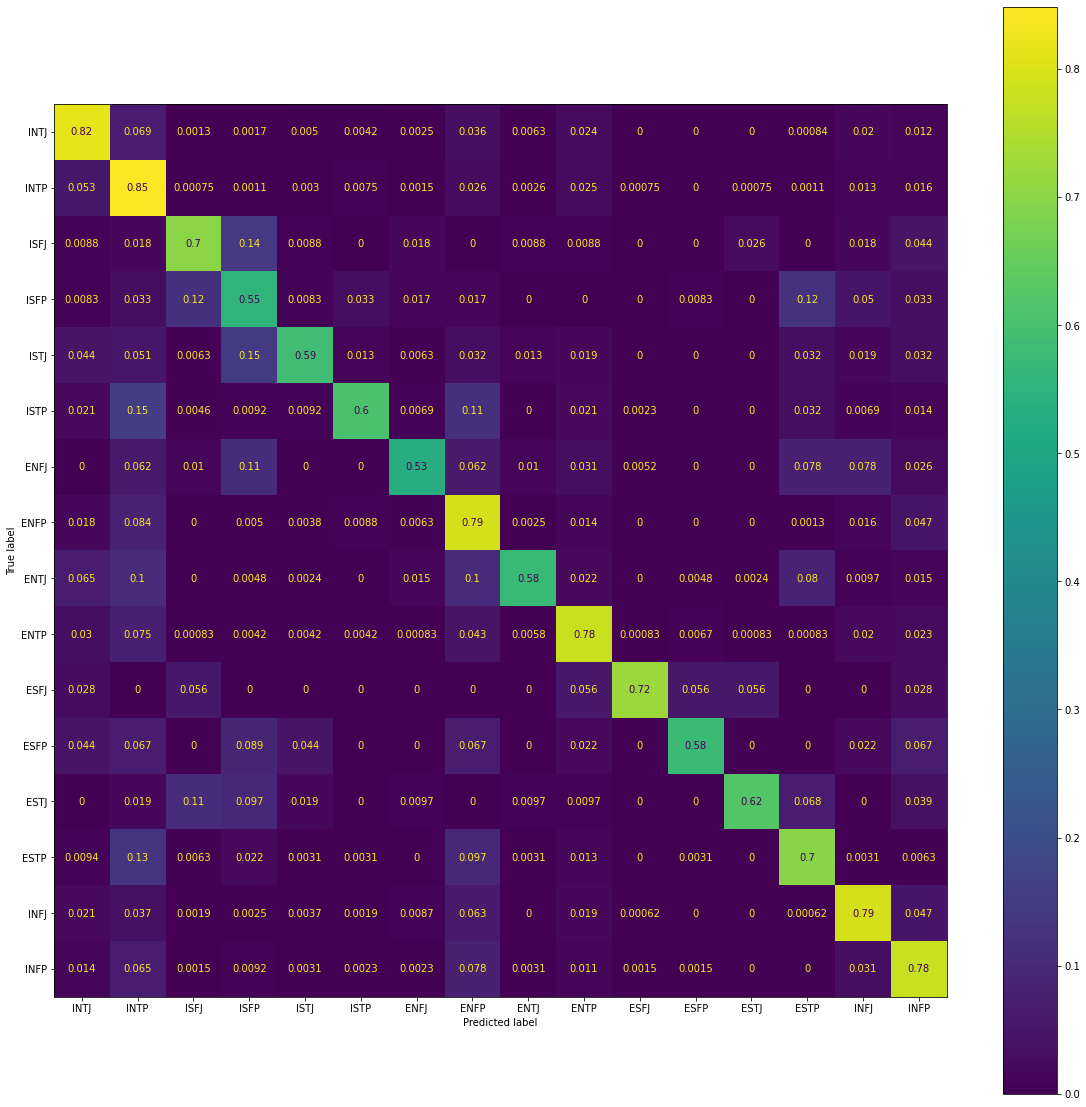

In [12]:
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(true_labels, predictions_labels, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)